In [1]:
import cv2
import os

import numpy as np
import pandas as pd
import random
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt

from utils.utils import *
from utils.display import plot_images, plot_coins
from utils.localization import *

import skimage

train_folder = 'data/train'
test_folder = 'data/test'
mode = 'train'

In [2]:
def image_type(row):
    id = int(row['id'][5:])
    if 277 <= id <= 323 or 405 <= id <= 454:
        return 0
    elif 325 <= id <= 370 or 462 <= id <= 503:
        return 1
    else:
        return 2

data = pd.read_csv('data/train_labels.csv').sort_values(by='id')
data['type'] = data.apply(image_type, axis=1)

data

,id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD,type
6,L1010277,1,0,0,0,0,0,0,1,0,1,2,0,0,0,0,0,0
10,L1010279,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
0,L1010281,0,0,0,0,2,3,1,0,0,0,0,0,2,0,0,0,0
15,L1010283,0,0,0,1,0,0,0,1,0,2,1,0,1,0,0,0,0
8,L1010287,0,1,1,0,0,0,1,0,0,0,0,2,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,L1010515,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2
74,L1010517,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2
78,L1010521,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2
80,L1010523,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,2


In [3]:
# Replace 'path_to_your_folder' with the path to the folder containing your images
if mode == 'train':
    images = load_images_from_folder(train_folder)
    labels = data.loc[:,'5CHF':'OOD'].values
    types = data['type'].values
else:
    images = load_images_from_folder(test_folder)
    types = [classify_background(img) for img in images]



labels_names = data.loc[:,'5CHF':'OOD'].columns

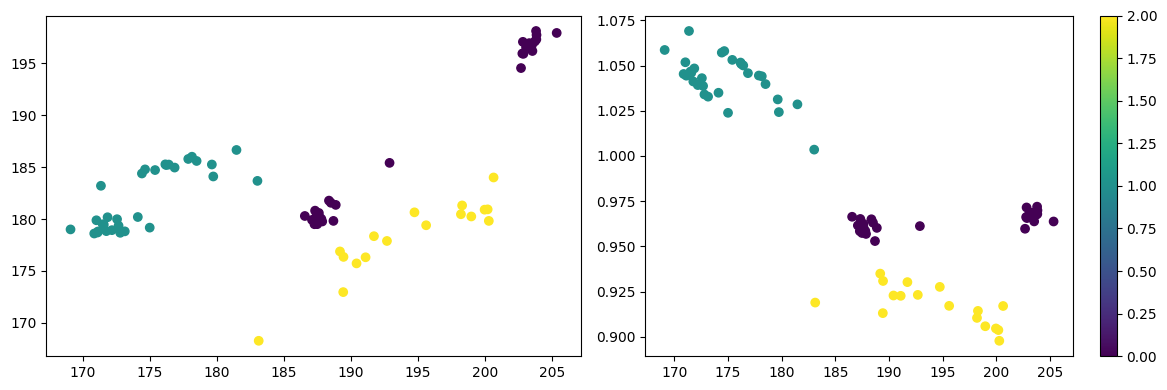

In [4]:
Mean_color = np.zeros((len(images),3))
for i in range(len(images)):
    Mean_color[i,:] = images[i].mean(axis=(0,1))
    
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(Mean_color[:,0], Mean_color[:,1], c=types, cmap='viridis')

sc = axs[1].scatter(Mean_color[:,0], Mean_color[:,1]/Mean_color[:,0], c=types, cmap='viridis')

plt.colorbar(sc)
plt.tight_layout()
plt.show()

In [5]:
target_type = 2 # -1 for all
max_images = -1 # -1 for all
seed = random.randint(0, 100)

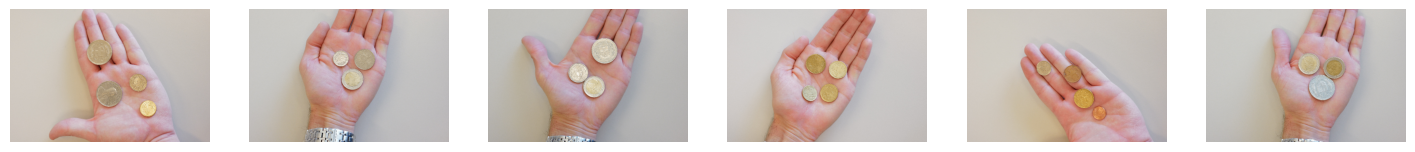

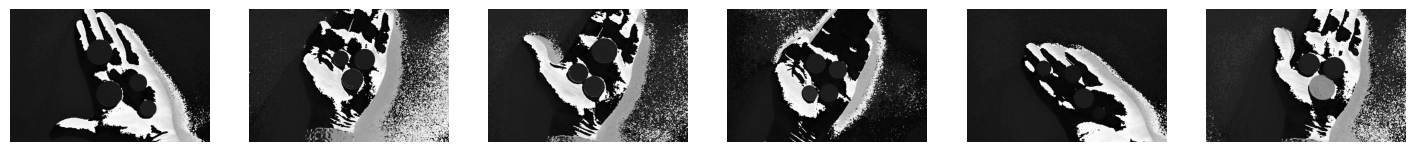

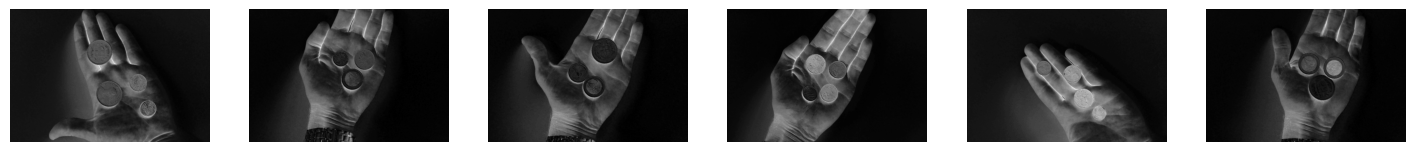

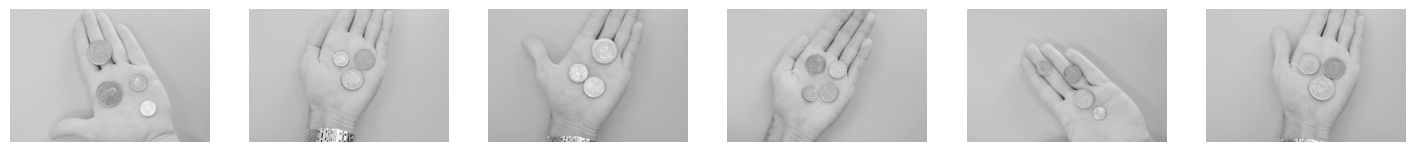

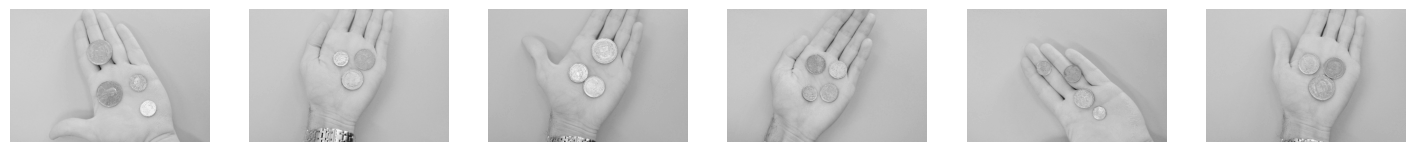

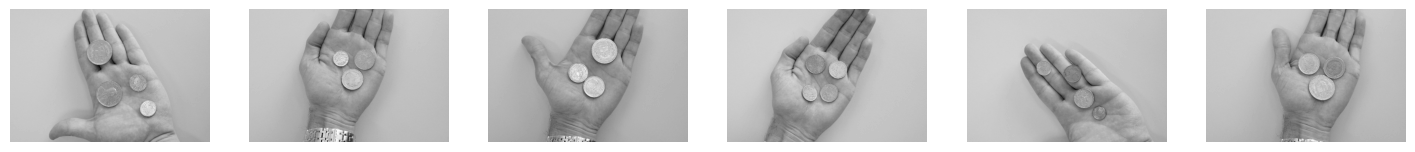

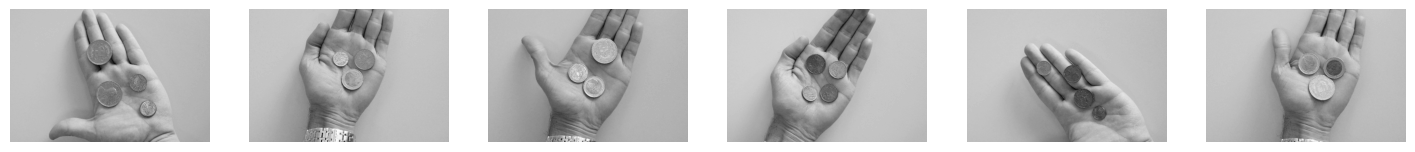

In [6]:
hue = [cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,0] for img in images]
saturation = [cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,1] for img in images]
value = [cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,2] for img in images]

red = [img[:,:,0] for img in images]
green = [img[:,:,1] for img in images]
blue = [img[:,:,2] for img in images]

plot_images(select_random_images(images, types, target_type, 6, seed))
plot_images(select_random_images(hue, types, target_type, 6, seed))
plot_images(select_random_images(saturation, types, target_type, 6, seed))
plot_images(select_random_images(value, types, target_type, 6, seed))
plot_images(select_random_images(red, types, target_type, 6, seed))
plot_images(select_random_images(green, types, target_type, 6, seed))
plot_images(select_random_images(blue, types, target_type, 6, seed))

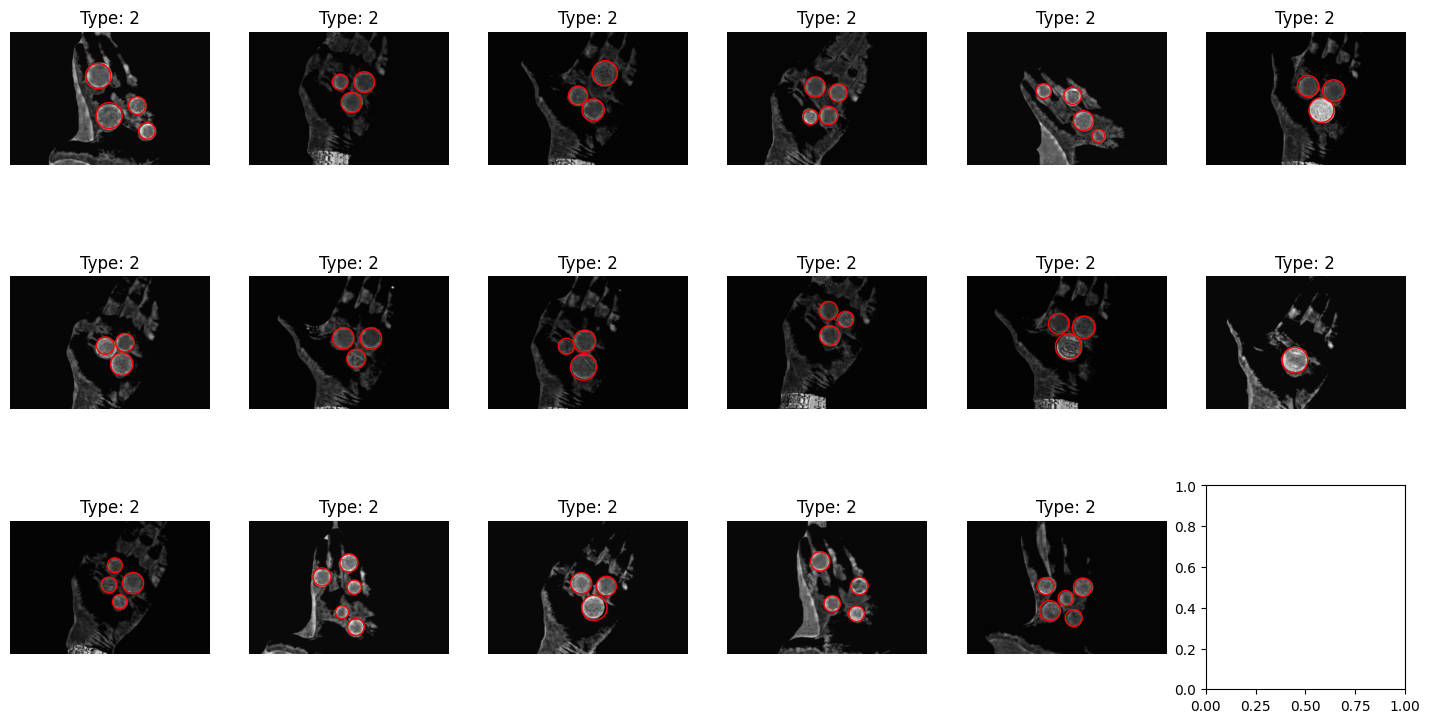

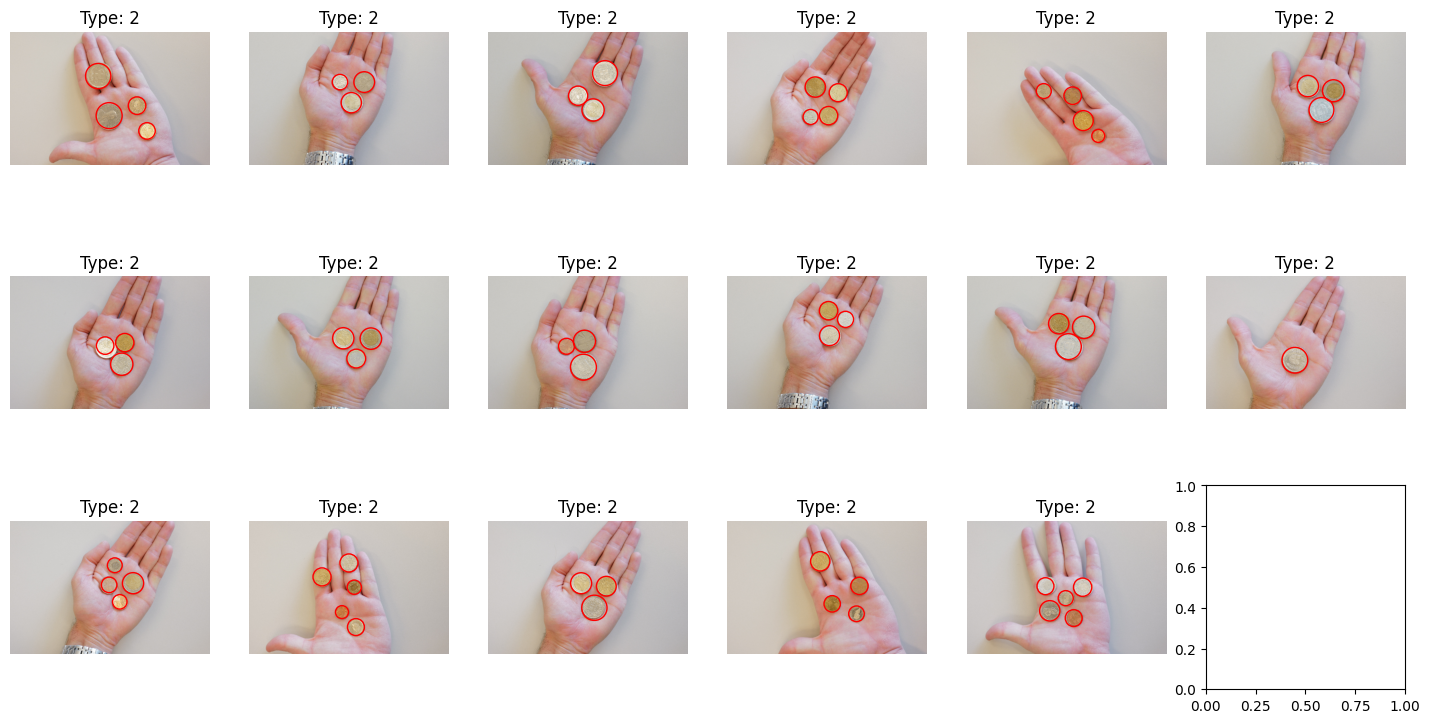

In [7]:
sample_images = select_random_images(images, types, target_type, max_images, seed)

tmp_images = []
types_list = []
circles_list = []

for i, image in enumerate(sample_images):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hue, saturation, value = cv2.split(hsv_image)

    type = classify_background(image)
    types_list.append(type)

    if type == 0 or type == "Plain":
        # Pre-process with Gaussian Blur
        tmp = cv2.GaussianBlur(saturation, (9, 9), 2)

        circles_tmp = cv2.HoughCircles(tmp,cv2.HOUGH_GRADIENT_ALT,1.5,20, param1=100,param2=0.78,minRadius=15,maxRadius=50)

    elif type == 1 or type == "Textured":
        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        tmp = (saturation.astype(np.float32)-hue.astype(np.float32)).clip(0,255).astype(np.uint8)
        tmp = clahe.apply(tmp)

        # Pre-process with Gaussian Blur
        tmp = cv2.GaussianBlur(tmp, (3, 3), 2)

        circles_tmp = cv2.HoughCircles(tmp,cv2.HOUGH_GRADIENT_ALT,1.5,20, param1=100,param2=0.8,minRadius=15,maxRadius=50)

    else: # Hand background        
        # Threshold the HSV image to get only skin colors
        skin_mask = ((image[:,:,0].astype(np.float32)-image[:,:,1].astype(np.float32))>20).astype(np.uint8)
        
        # Apply morphological operations to clean up the mask
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21))
        skin_mask = cv2.dilate(skin_mask, kernel, iterations = 5)
        skin_mask = cv2.erode(skin_mask, kernel, iterations = 5)     
        
        # Bitwise-AND mask and original image
        hue = cv2.bitwise_and(hue, hue, mask=skin_mask)

        mask2 = (hue>3) & (hue<110)
        tmp = cv2.bitwise_and(hue, hue, mask=mask2.astype(np.uint8))

        # Apply CLAHE on masked saturation channel
        clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(50, 50))
        tmp= clahe.apply(tmp)

        # Pre-process with Gaussian Blur
        tmp = cv2.GaussianBlur(tmp, (3, 3), 2)

        circles_tmp = cv2.HoughCircles(tmp,cv2.HOUGH_GRADIENT_ALT,1.5,20, param1=400,param2=0.7,minRadius=15,maxRadius=50)

        
    tmp_images.append(tmp)
    if circles_tmp is not None:
            circles = remove_overlapping_circles(circles_tmp[0], epsilon=10)
    else:
        circles = []
    circles_list.append(circles)

plot_images(tmp_images,coins_coord=circles_list, types=types_list)
plot_images(sample_images,coins_coord=circles_list, types=types_list)